<a href="https://colab.research.google.com/github/ngebodh/MachineLearning/blob/master/SVM/EigenFaces_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eigen Faces
Here we use principal component analysis (PCA) to reduce the number of features in a dataset of faces.
The PC's are then fed into a Support Vector Machine (SVM) classifier to classify the faces based on learned features.


The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka [LFW]('http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz')

[More on LFW]('http://vis-www.cs.umass.edu/lfw/')

[Other resources]('http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html')


## Import the libraries
Here we import the libraries that we need for later

In [ ]:
from time import time
import logging
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt

# !pip install -U scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


In [ ]:
#Display progress
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


## Get the data
Here we pull in the data and store it in numpy arrays



In [3]:
#Download the data
lfw_people =fetch_lfw_people(min_faces_per_person=70, resize=0.4)

#Find out shape infomration about the images to help with plotting them
n_samples, h, w=lfw_people.images.shape

np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the ID of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print ("Total dataset size:")
print ("n_samples: %d" % n_samples)
print ("n_features: %d" % n_features)
print ("n_classes: %d" % n_classes)
print ("Classes: %s" % target_names)

2019-07-19 05:21:21,839 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012
2019-07-19 05:21:28,215 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2019-07-19 05:21:29,542 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2019-07-19 05:21:31,138 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Classes: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


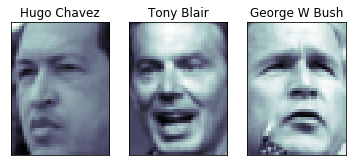

In [4]:
#Lets look at the data to see what they look like

pl.figure
for i in range(0,3):
  pl.subplot(1,3,i+1)
  pl.imshow(X[i].reshape((h,w)), cmap=pl.cm.bone)
  pl.title(target_names[lfw_people.target[i]])
  pl.xticks(())
  pl.yticks(())
  

##Split Data (Test|Train)
Here we split the data into a testing and train set

In [5]:
X_train, X_test, y_train, y_test =train_test_split(X,y, test_size=0.25, random_state=42)
y_test.dtype

dtype('int64')

##Do PCA and Dimensionality Reduction on Data
Now we compute the PC's using PCA

Extracting the top 250 eignefaces from 966 faces
Done in 0.399s


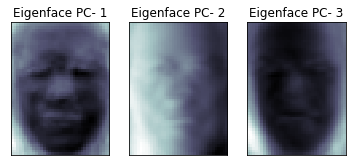

In [6]:

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 250

print("Extracting the top %d eignefaces from %d faces" % (n_components, X_train.shape[0]))

#Initiate a time counter (kinda like tic toc)
t0=time()

#Here we take the training data and compute the PCs
pca=PCA(n_components=n_components, whiten=True).fit(X_train)


#Print the time it took to compute
print("Done in %0.3fs" % (time()-t0))



#Reshape the PCs to the image format
eigenfaces =pca.components_.reshape((n_components,h,w))

pl.figure
for i in range(0,3):
  pl.subplot(1,3,i+1)
  pl.imshow(eigenfaces[i], cmap=pl.cm.bone)
  pl.title("Eigenface PC- %d" % (i+1))
  pl.xticks(())
  pl.yticks(())
#   cbar = pl.colorbar()
#   cbar.solids.set_edgecolor("face")
#   pl.draw()

# print(pca.explained_variance_ )
# print(pca.explained_variance_ratio_)



### Look at the top PC's
Here we're going to plot the top PCs identified

(250,)

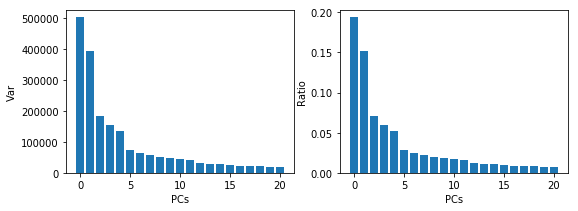

In [37]:
top_pcs=21
plt.figure( figsize=(9, 3))
plt.subplot(121)
plt.bar(np.arange(top_pcs),pca.explained_variance_[0:top_pcs])
plt.xlabel('PCs')
plt.ylabel('Var')

plt.subplot(122)
plt.bar(np.arange(top_pcs),pca.explained_variance_ratio_[0:top_pcs])
plt.xlabel('PCs')
plt.ylabel('Ratio')

np.shape(pca.explained_variance_)

### Projecting the PCs
Now that we have the PCs (the vectors that account for the max variances) we can project the data down to the PCs. In this case they are the eigenfaces from above.


In [7]:
print("Projecting the input data on the eignefaces orthonormal basis")

t0=time()#tic

X_train_pca = pca.transform(X_train) #take the training data and project it to eigenfaces
X_test_pca  = pca.transform(X_test)#take the test data and project it to eigenfaces
print("Done in %0.3fs" % (time()- t0)) #toc

Projecting the input data on the eignefaces orthonormal basis
Done in 0.035s


##Train a SVM Classification Model

So now that we have the most important features extracted out by PCA we can use those to train a classifier. The SVM classifier can then be used to predict who's face is being presented


In [8]:
#Training

print ("Fitting the classifier to the training set")
t0 = time()
#These set parameters that we want to optimize. These are passed to GridSearch
#which uses the optimal paramters in the fitting classifier =clf
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print ("done in %0.3fs" % (time() - t0))
print ("Best estimator found by grid search:")
print (clf.best_estimator_)

Fitting the classifier to the training set


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


done in 39.016s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [9]:
#Testing the classifier 

print ("Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print ("done in %0.3fs" % (time() - t0))

print (classification_report(y_test, y_pred, target_names=target_names))
print (confusion_matrix(y_test, y_pred, labels=range(n_classes)))



Predicting the people names on the testing set
done in 0.125s
                   precision    recall  f1-score   support

     Ariel Sharon       0.64      0.69      0.67        13
     Colin Powell       0.75      0.90      0.82        60
  Donald Rumsfeld       0.82      0.67      0.73        27
    George W Bush       0.91      0.92      0.91       146
Gerhard Schroeder       0.87      0.80      0.83        25
      Hugo Chavez       0.80      0.53      0.64        15
       Tony Blair       0.82      0.78      0.80        36

         accuracy                           0.84       322
        macro avg       0.80      0.76      0.77       322
     weighted avg       0.84      0.84      0.84       322

[[  9   1   1   2   0   0   0]
 [  1  54   2   2   0   1   0]
 [  2   3  18   3   0   0   1]
 [  1   6   1 134   1   1   2]
 [  0   2   0   1  20   0   2]
 [  0   4   0   2   0   8   1]
 [  1   2   0   3   2   0  28]]


##Visualizing Results
Now that we've trained and tested the SVM to classify faces lets visualized the results

In [ ]:
#Create a helper function to look at the pictures
                         
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])] 

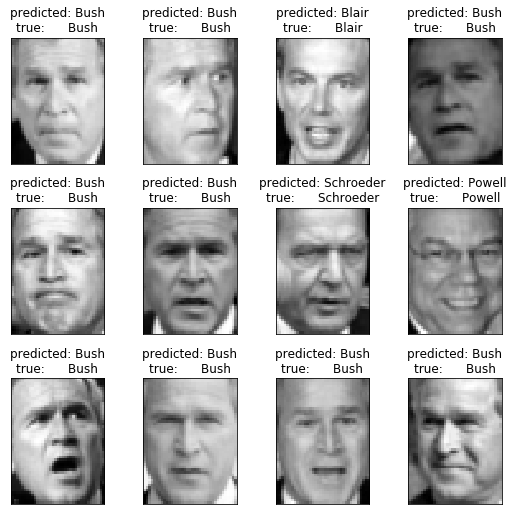

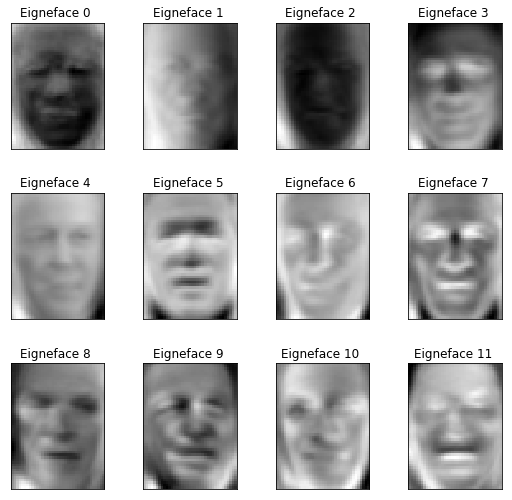

In [11]:
#Now print out preductions
# prediction_titles=(X_test, prediction_titles,h,w)

plot_gallery(X_test, prediction_titles, h, w )

#Plot the eignefaces

eigenface_titles =["Eigneface %d " % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()